# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import tensorflow.keras as keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = [1e-1, 1e-3]
EPOCHS = 50
BATCH_SIZE = 256
OPTIMIZER = [keras.optimizers.SGD(decay=1e-6, nesterov=True, momentum=0.9), 
             keras.optimizers.RMSprop(),
             keras.optimizers.Adagrad(),
             keras.optimizers.Adam()]

In [7]:
results = {}

for op in OPTIMIZER:
    for lr in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        opname = op.get_config()['name']
        print("Experiment with LR = %.2f" % (lr), (opname))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        op.lr = lr
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=op)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-lr-%s" % str(lr)+str(opname)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with LR = 0.10 SGD
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

50000/50000 [==============================] - 3s 61us/sample - loss: 1.1150 - accuracy: 0.5996 - val_loss: 1.6232 - val_accuracy: 0.4698
Epoch 49/50
50000/50000 [==============================] - 3s 65us/sample - loss: 1.1072 - accuracy: 0.6052 - val_loss: 1.6358 - val_accuracy: 0.4795
Epoch 50/50
50000/50000 [==============================] - 3s 65us/sample - loss: 1.1043 - accuracy: 0.6024 - val_loss: 1.6222 - val_accuracy: 0.4753
Experiment with LR = 0.00 SGD
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_______________________________________________________

50000/50000 [==============================] - 3s 61us/sample - loss: 1.1776 - accuracy: 0.5867 - val_loss: 1.3964 - val_accuracy: 0.5071
Epoch 46/50
50000/50000 [==============================] - 3s 61us/sample - loss: 1.1691 - accuracy: 0.5903 - val_loss: 1.3450 - val_accuracy: 0.5197
Epoch 47/50
50000/50000 [==============================] - 3s 60us/sample - loss: 1.1619 - accuracy: 0.5912 - val_loss: 1.3444 - val_accuracy: 0.5165
Epoch 48/50
50000/50000 [==============================] - 3s 59us/sample - loss: 1.1507 - accuracy: 0.5937 - val_loss: 1.3651 - val_accuracy: 0.5099
Epoch 49/50
50000/50000 [==============================] - 3s 59us/sample - loss: 1.1456 - accuracy: 0.5975 - val_loss: 1.3961 - val_accuracy: 0.5083
Epoch 50/50
50000/50000 [==============================] - 3s 60us/sample - loss: 1.1356 - accuracy: 0.6028 - val_loss: 1.3522 - val_accuracy: 0.5239
Experiment with LR = 0.10 RMSprop
Model: "model"
_______________________________________________________________

50000/50000 [==============================] - 6s 119us/sample - loss: 2.3083 - accuracy: 0.0992 - val_loss: 2.3106 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 5s 103us/sample - loss: 2.3078 - accuracy: 0.0986 - val_loss: 2.3138 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 5s 92us/sample - loss: 2.3081 - accuracy: 0.1002 - val_loss: 2.3131 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 4s 85us/sample - loss: 2.3080 - accuracy: 0.1008 - val_loss: 2.3085 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 4s 84us/sample - loss: 2.3077 - accuracy: 0.0986 - val_loss: 2.3076 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 4s 84us/sample - loss: 2.3079 - accuracy: 0.0979 - val_loss: 2.3125 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 4s 86us/sample - loss: 2.3077 - accuracy: 0.1007 - 

50000/50000 [==============================] - 5s 97us/sample - loss: 0.9099 - accuracy: 0.6749 - val_loss: 1.7832 - val_accuracy: 0.4836
Epoch 40/50
50000/50000 [==============================] - 5s 95us/sample - loss: 0.8947 - accuracy: 0.6808 - val_loss: 1.7227 - val_accuracy: 0.4882
Epoch 41/50
50000/50000 [==============================] - 5s 100us/sample - loss: 0.8813 - accuracy: 0.6848 - val_loss: 1.7815 - val_accuracy: 0.4737
Epoch 42/50
50000/50000 [==============================] - 5s 92us/sample - loss: 0.8617 - accuracy: 0.6906 - val_loss: 1.6947 - val_accuracy: 0.4946
Epoch 43/50
50000/50000 [==============================] - 5s 94us/sample - loss: 0.8534 - accuracy: 0.6949 - val_loss: 1.8429 - val_accuracy: 0.4750
Epoch 44/50
50000/50000 [==============================] - 5s 92us/sample - loss: 0.8432 - accuracy: 0.6968 - val_loss: 1.8434 - val_accuracy: 0.4958
Epoch 45/50
50000/50000 [==============================] - 5s 97us/sample - loss: 0.8264 - accuracy: 0.7027 - v

50000/50000 [==============================] - 4s 80us/sample - loss: 1.0924 - accuracy: 0.6058 - val_loss: 1.6969 - val_accuracy: 0.4457
Epoch 37/50
50000/50000 [==============================] - 4s 77us/sample - loss: 1.0807 - accuracy: 0.6118 - val_loss: 1.5363 - val_accuracy: 0.4779
Epoch 38/50
50000/50000 [==============================] - 4s 79us/sample - loss: 1.0601 - accuracy: 0.6188 - val_loss: 1.7020 - val_accuracy: 0.4508
Epoch 39/50
50000/50000 [==============================] - 4s 75us/sample - loss: 1.0551 - accuracy: 0.6182 - val_loss: 1.5312 - val_accuracy: 0.4892
Epoch 40/50
50000/50000 [==============================] - 4s 83us/sample - loss: 1.0269 - accuracy: 0.6317 - val_loss: 1.4884 - val_accuracy: 0.5043
Epoch 41/50
50000/50000 [==============================] - 4s 76us/sample - loss: 1.0115 - accuracy: 0.6369 - val_loss: 1.5990 - val_accuracy: 0.4826
Epoch 42/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.0020 - accuracy: 0.6397 - va

50000/50000 [==============================] - 4s 85us/sample - loss: 1.5955 - accuracy: 0.4457 - val_loss: 1.6119 - val_accuracy: 0.4336
Epoch 34/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.5901 - accuracy: 0.4463 - val_loss: 1.6054 - val_accuracy: 0.4371
Epoch 35/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.5851 - accuracy: 0.4476 - val_loss: 1.5984 - val_accuracy: 0.4369
Epoch 36/50
50000/50000 [==============================] - 4s 88us/sample - loss: 1.5803 - accuracy: 0.4496 - val_loss: 1.6020 - val_accuracy: 0.4384
Epoch 37/50
50000/50000 [==============================] - 4s 82us/sample - loss: 1.5758 - accuracy: 0.4526 - val_loss: 1.5916 - val_accuracy: 0.4402
Epoch 38/50
50000/50000 [==============================] - 4s 85us/sample - loss: 1.5707 - accuracy: 0.4529 - val_loss: 1.5900 - val_accuracy: 0.4372
Epoch 39/50
50000/50000 [==============================] - 4s 89us/sample - loss: 1.5665 - accuracy: 0.4550 - va

50000/50000 [==============================] - 3s 63us/sample - loss: 2.3081 - accuracy: 0.0997 - val_loss: 2.3100 - val_accuracy: 0.1000
Epoch 31/50
50000/50000 [==============================] - 3s 61us/sample - loss: 2.3067 - accuracy: 0.1003 - val_loss: 2.3054 - val_accuracy: 0.1000
Epoch 32/50
50000/50000 [==============================] - 3s 61us/sample - loss: 2.3064 - accuracy: 0.1006 - val_loss: 2.3107 - val_accuracy: 0.1000
Epoch 33/50
50000/50000 [==============================] - 3s 65us/sample - loss: 2.3071 - accuracy: 0.0990 - val_loss: 2.3092 - val_accuracy: 0.1000
Epoch 34/50
50000/50000 [==============================] - 3s 65us/sample - loss: 2.3073 - accuracy: 0.1000 - val_loss: 2.3058 - val_accuracy: 0.1000
Epoch 35/50
50000/50000 [==============================] - 3s 62us/sample - loss: 2.3064 - accuracy: 0.1000 - val_loss: 2.3058 - val_accuracy: 0.1000
Epoch 36/50
50000/50000 [==============================] - 3s 61us/sample - loss: 2.3065 - accuracy: 0.1002 - va

50000/50000 [==============================] - 3s 61us/sample - loss: 1.2588 - accuracy: 0.5514 - val_loss: 1.4429 - val_accuracy: 0.5015
Epoch 28/50
50000/50000 [==============================] - 3s 60us/sample - loss: 1.2391 - accuracy: 0.5574 - val_loss: 1.4260 - val_accuracy: 0.5003
Epoch 29/50
50000/50000 [==============================] - 3s 58us/sample - loss: 1.2283 - accuracy: 0.5641 - val_loss: 1.4584 - val_accuracy: 0.4881
Epoch 30/50
50000/50000 [==============================] - 3s 61us/sample - loss: 1.2233 - accuracy: 0.5633 - val_loss: 1.4516 - val_accuracy: 0.4944
Epoch 31/50
50000/50000 [==============================] - 3s 63us/sample - loss: 1.2160 - accuracy: 0.5654 - val_loss: 1.4627 - val_accuracy: 0.4897
Epoch 32/50
50000/50000 [==============================] - 3s 63us/sample - loss: 1.2067 - accuracy: 0.5681 - val_loss: 1.4293 - val_accuracy: 0.5050
Epoch 33/50
50000/50000 [==============================] - 3s 62us/sample - loss: 1.1967 - accuracy: 0.5717 - va

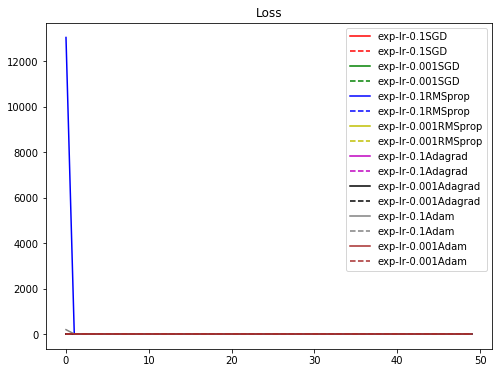

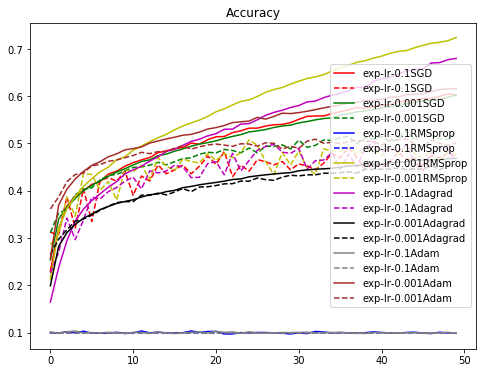

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k", "grey", "brown"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()